# **1. Définition du problème**

La Banque Nationale de Sécurité Monétaire (BNSM) souhaite développer une solution automatisée capable d’identifier les faux billets en euros à partir de leurs caractéristiques physiques.

Dans un contexte où la contrefaçon monétaire représente une menace importante pour la stabilité économique et la confiance du public, la mise en place d’un système intelligent de détection rapide et fiable constitue un enjeu majeur.

Pour ce faire, un jeu de données est mis à disposition, comprenant **1 501** observations :

<br>

**1 001 vrais billets et 500 faux billets.**
Chaque billet est décrit par six variables numériques représentant ses caractéristiques dimensionnelles :

* **diagonal** : longueur de la diagonale du billet

* **height_left** : hauteur mesurée à gauche

* **height_right** : hauteur mesurée à droite

* **margin_low** : marge inférieure

* **margin_up** : marge supérieure

* **length** : longueur totale

<br>

La variable cible **is_genuine** indique si le billet est authentique (True) ou contrefait (False).
<br>
L’objectif est de concevoir un modèle de **classification supervisée** capable de prédire la nature d’un billet à partir de ses dimensions.

# **2. Méthodologie envisagée**

1.  **Analyse exploratoire des données (EDA)**

    * Étude statistique des variables : distributions, corrélations, détection d’anomalies.

    * Visualisation des différences entre vrais et faux billets pour identifier les variables discriminantes.

2. **Préparation des données**

   * Gestion des valeurs manquantes (imputation).

   * Normalisation ou standardisation des variables si nécessaire.

   * Séparation des jeux d’entraînement et de test.

3. **Modélisation**
   * Plusieurs familles de modèles seront testées afin de comparer leurs performances :

   * Modèles linéaires : Régression Logistique

   * Modèles à base d’arbre : Random Forest, XGBoost

4. **Évaluation des performances**

   *  Mise en place d’un score (ex. : Accuracy, F1-score, AUC-ROC) pour évaluer la qualité de la prédiction.

   * Comparaison des modèles pour sélectionner le meilleur compromis entre performance et interprétabilité.

5. **Déploiement de l’application**

   * Développement d’une application de détection automatique permettant de saisir les dimensions d’un billet et d’obtenir instantanément le verdict (vrai ou faux).

# **3. Objectif final**

Fournir à l’BNSM une solution intelligente et opérationnelle permettant :

* d’automatiser la détection des faux billets,

* de réduire le taux d’erreur humaine,

* et de renforcer la fiabilité du contrôle monétaire grâce à l’intelligence artificielle.

# **4. Importation des bibliothèques et chargement du dataset**
> **Objectif** :
 Charger les données, visualiser la structure du jeu de données et vérifier la cohérence des variables.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import drive
from scipy.stats import kstest, norm, shapiro
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib
from xgboost import XGBClassifier

 ## **4.1 Collecte** : récupérer le dataset (Google Drive).

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_dir = '/content/drive/My Drive/Datasets Google Colab/Counterfeit-money-dataset'

In [ ]:

# Dossier où les modèles sont sauvegardés
save_dir = "/content/drive/MyDrive/saved_models/detection_faux_billets"

In [ ]:
os.makedirs(save_dir, exist_ok=True)



In [ ]:
#Contenu du repertoire
noms_fichiers = os.listdir(df_dir)
print(noms_fichiers)

['fake_bills.csv']


## **4.2 Chargement et aperçu du dataset**

In [ ]:
df = pd.read_csv(os.path.join(df_dir,'fake_bills.csv'), sep =';')

### **4.2.1 Aperçu des 5 premières lignes**

In [ ]:
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


### **4.2.2 Aperçu des 5 dernières lignes**

In [ ]:
df.tail()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
1496,False,171.75,104.38,104.17,4.42,3.09,111.28
1497,False,172.19,104.63,104.44,5.27,3.37,110.97
1498,False,171.80,104.01,104.12,5.51,3.36,111.95
1499,False,172.06,104.28,104.06,5.17,3.46,112.25
1500,False,171.47,104.15,103.82,4.63,3.37,112.07


### **4.2.3 Informations générales du dataframe**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1501 entries, 0 to 1500
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1501 non-null   bool   
 1   diagonal      1501 non-null   float64
 2   height_left   1501 non-null   float64
 3   height_right  1501 non-null   float64
 4   margin_low    1464 non-null   float64
 5   margin_up     1501 non-null   float64
 6   length        1501 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 72.0 KB


### **4.2.4 Statistiques descriptives**

In [ ]:
df.describe()


,diagonal,height_left,height_right,margin_low,margin_up,length
count,1501.000000,1501.000000,1501.000000,1464.000000,1501.000000,1501.000000
mean,171.958288,104.029460,103.920187,4.485929,3.151226,112.678701
std,0.305150,0.299375,0.325552,0.663587,0.231934,0.872474
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.490000
25%,171.750000,103.820000,103.710000,4.017500,2.990000,112.030000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.960000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.340000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.440000


In [ ]:
print(df['is_genuine'].value_counts())

is_genuine
True     1001
False     500
Name: count, dtype: int64


# **5. Exploration des données (EDA)**
>**Objectifs** : Comprendre la structure du dataset, détecter les anomalies, observer les relations entre variables et la distribution des classes.

## **5.1 Vérification des valeurs manquantes et doublons**

In [ ]:
print("Valeurs manquantes :")
df.isna().sum()

Valeurs manquantes :


,0
is_genuine,0
diagonal,0
height_left,0
height_right,0
margin_low,37
margin_up,0
length,0


In [ ]:
print("Pourcentage de Valeurs manquantes :")
df.isna().mean() * 100

Pourcentage de Valeurs manquantes :


,0
is_genuine,0.000000
diagonal,0.000000
height_left,0.000000
height_right,0.000000
margin_low,2.465023
margin_up,0.000000
length,0.000000


## **5.2 Vérification des doublons**

In [ ]:
print(f"\nNombre de doublons : {df.duplicated().sum()}")


Nombre de doublons : 1


## **5.3 Répartition de la variable cible**

/tmp/ipython-input-325612324.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='is_genuine', palette='coolwarm')


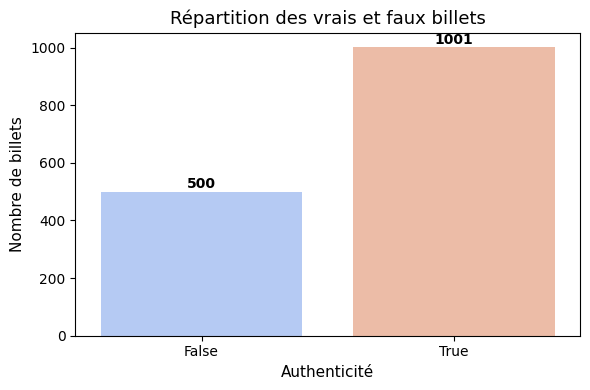

Pourcentage de vrais/faux billets :
is_genuine
True     66.69
False    33.31
Name: proportion, dtype: float64


In [ ]:
# Répartition des vrais et faux billets
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='is_genuine', palette='coolwarm')

# Ajouter les étiquettes de valeurs au-dessus des barres
for p in ax.patches:
    height = p.get_height()
    ax.text(
        p.get_x() + p.get_width() / 2,  # position horizontale (centre de la barre)
        height + 1,                     # position verticale légèrement au-dessus
        f'{int(height)}',               # texte affiché (converti en entier)
        ha='center', va='bottom', fontsize=10, fontweight='bold'
    )

# Titres et labels
plt.title("Répartition des vrais et faux billets", fontsize=13)
plt.xlabel("Authenticité", fontsize=11)
plt.ylabel("Nombre de billets", fontsize=11)
plt.tight_layout()
plt.show()

# Pourcentage de vrais/faux billets
print("Pourcentage de vrais/faux billets :")
print(df['is_genuine'].value_counts(normalize=True).mul(100).round(2))


## **5.4 Visualisation de la distribution des variables**

### **5.4.1 Méthodes visuelles**

In [ ]:
num_cols = ['diagonal','height_left','height_right','margin_low','margin_up','length']

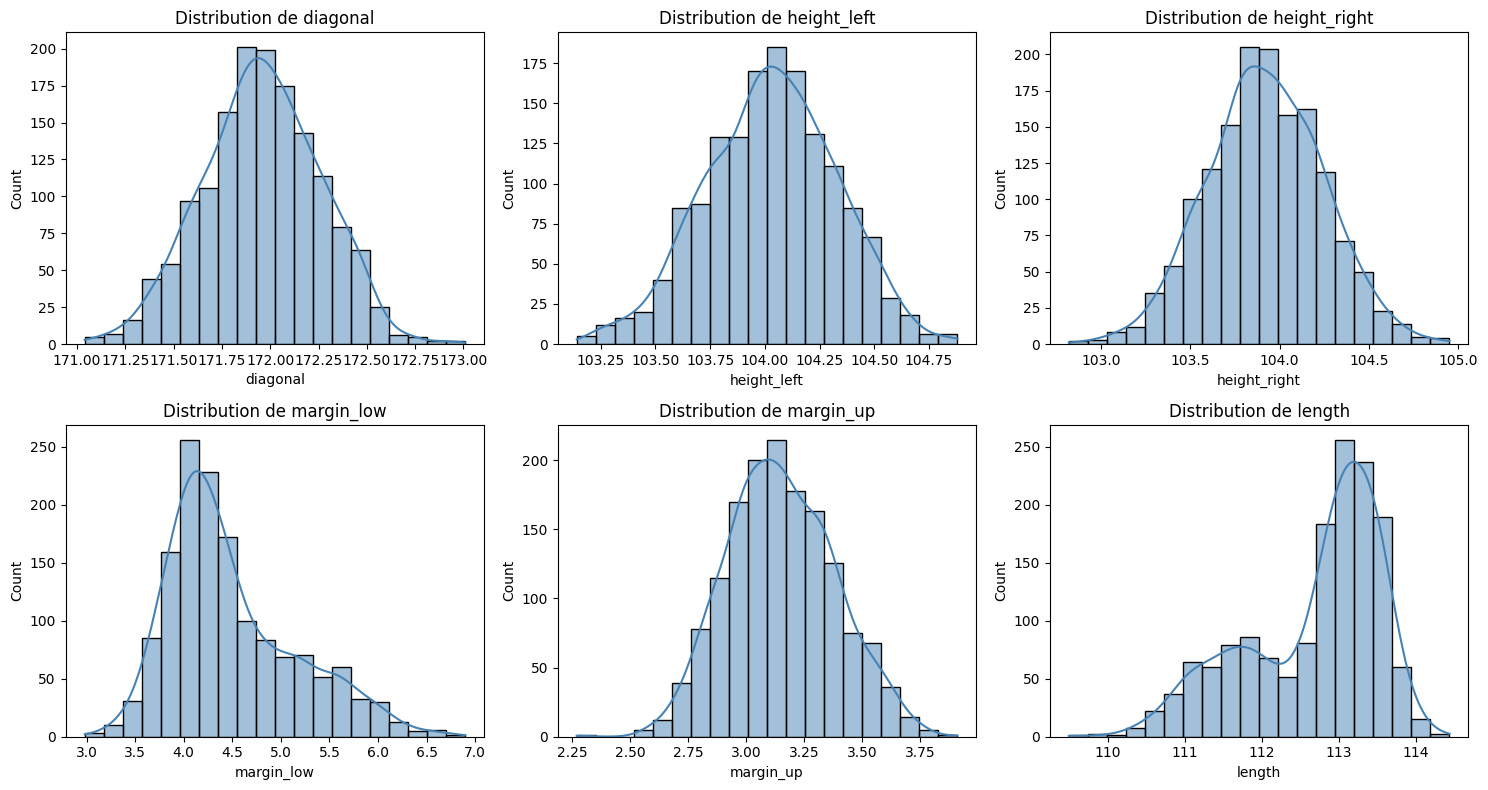

In [ ]:
# Vérifier que les colonnes existent
num_cols = [col for col in num_cols if col in df.columns]

# Définir la taille de la figure et la grille
n_cols = 3  # nombre de colonnes dans la grille
n_rows = (len(num_cols) + n_cols - 1) // n_cols  # nombre de lignes nécessaire

plt.figure(figsize=(5*n_cols, 4*n_rows))

# Boucle pour créer chaque subplot
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=20, color='steelblue', edgecolor='black')
    plt.title(f"Distribution de {col}")

plt.tight_layout()
plt.show()


### **5.4.2 Méthodes statistiques**

**Test de Shapiro-Wilk VS Test de Kolmogorov-Smirnov**

In [ ]:
# Créer un tableau pour résumer les résultats
results = []

alpha = 0.05  # seuil classique

for col in num_cols:
    data = df[col].dropna()  # ignorer les NaN

    if data.nunique() <= 1:
        results.append([col, 'Constante ou unique valeur', None, 'Test impossible'])
        continue

    # Choix de la méthode selon la taille
    if len(data) < 2000:
        method = 'Shapiro-Wilk'
        stat, p = shapiro(data)
    else:
        method = 'Kolmogorov-Smirnov'
        # Standardisation pour KS
        stat, p = kstest((data - data.mean()) / data.std(), 'norm')

    verdict = 'Normale' if p > alpha else 'Non normale'

    results.append([col, method, round(p, 5), verdict])

# Transformer en DataFrame pour affichage clair
summary = pd.DataFrame(results, columns=['Colonne', 'Méthode', 'p-value', 'Verdict'])
print(summary)


        Colonne       Méthode  p-value      Verdict
0      diagonal  Shapiro-Wilk  0.33212      Normale
1   height_left  Shapiro-Wilk  0.05344      Normale
2  height_right  Shapiro-Wilk  0.97933      Normale
3    margin_low  Shapiro-Wilk  0.00000  Non normale
4     margin_up  Shapiro-Wilk  0.00078  Non normale
5        length  Shapiro-Wilk  0.00000  Non normale


## **5.5 Comparaison entre vrais et faux billets**

/tmp/ipython-input-2786914821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_genuine', y=col, palette='coolwarm')
/tmp/ipython-input-2786914821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_genuine', y=col, palette='coolwarm')
/tmp/ipython-input-2786914821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='is_genuine', y=col, palette='coolwarm')
/tmp/ipython-input-2786914821.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assi

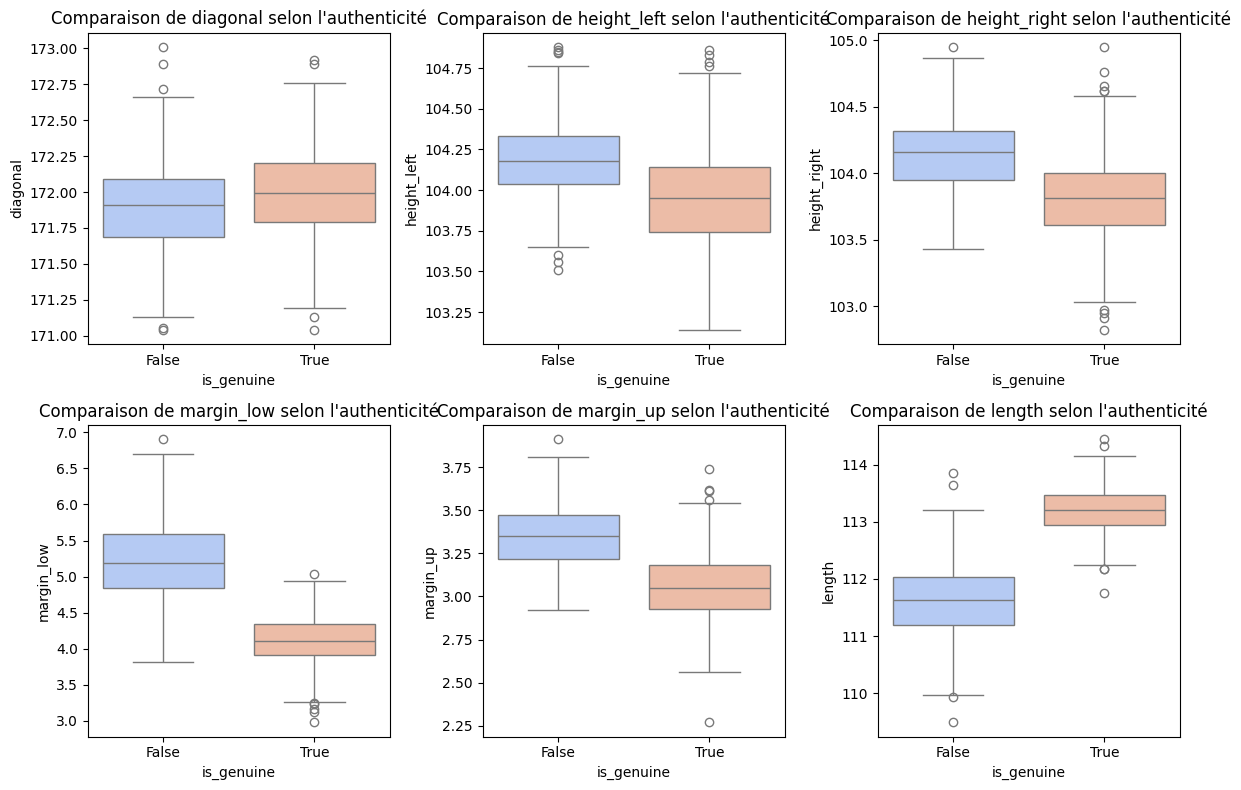

In [ ]:
# Boxplots pour comparer la distribution des variables selon la classe
plt.figure(figsize=(12, 8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='is_genuine', y=col, palette='coolwarm')
    plt.title(f"Comparaison de {col} selon l'authenticité")
plt.tight_layout()
plt.show()


## **5.6 Corrélations entre les variables**

**Valeur :	Interprétation**

**1**	: Corrélation positive parfaite

**0.7-0.9**	: Corrélation positive forte

**0.3-0.7**	: Corrélation positive modérée

**0-0.3**	: Corrélation faible

**0**	: Pas de corrélation linéaire

**-0.3 à -0.7**	: Corrélation négative modérée

**-0.7 à -0.9** :	Corrélation négative forte

**-1** :	Corrélation négative parfaite

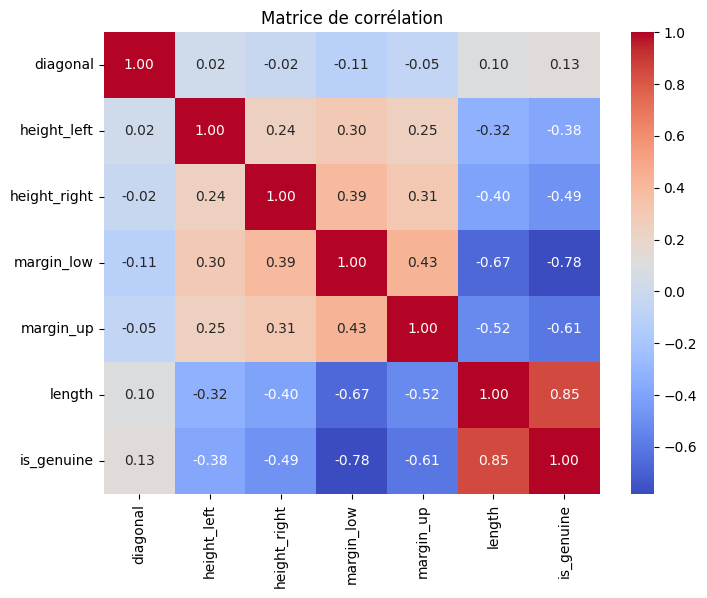

In [ ]:
# Matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(df[num_cols + ['is_genuine']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()


## **5.7 Identification des valeurs aberrantes (outliers)**

### **5.7.1 Méthode statistique : l’intervalle interquartile IQR (Distribution asymétrique ou avec valeurs extrêmes)**

> utilise la médiane et les quartiles.

In [ ]:
cols_non_normales = summary[summary['Verdict'] == 'Non normale']['Colonne'].tolist()

# Dictionnaire pour stocker les outliers
outliers_dict = {}

for col in cols_non_normales:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Sélection des outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outliers_dict[col] = outliers
    print(f"{col} : {len(outliers)} valeurs aberrantes")
    print(outliers)
    print()




margin_low : 24 valeurs aberrantes
      is_genuine  diagonal  height_left  height_right  margin_low  margin_up  \
1024       False    172.02       104.26        104.20        6.20       3.58   
1028       False    171.63       104.02        104.66        6.70       3.28   
1032       False    172.40       104.00        103.82        6.33       3.10   
1042       False    171.77       104.12        104.42        6.65       3.63   
1054       False    171.85       104.52        104.05        6.21       3.43   
1076       False    172.02       104.51        103.69        6.23       3.39   
1093       False    171.87       104.76        104.02        6.30       3.61   
1111       False    171.73       104.32        104.07        6.56       3.30   
1125       False    171.88       103.92        104.27        6.70       3.11   
1134       False    171.79       103.99        103.67        6.16       3.52   
1135       False    171.91       103.70        104.41        6.34       3.50   
1170 

###  **5.7.2 Détection avec Z-score (Distribution normale)**

>utilise la moyenne et l’écart-type.

In [ ]:
# Colonnes normales
cols_normales = summary[summary['Verdict'] == 'Normale']['Colonne'].tolist()
df_normales = df[cols_normales]

# Calcul du Z-score
z_scores = np.abs(stats.zscore(df_normales))

# Dictionnaire pour stocker les lignes outliers par colonne
outliers_per_col = {}

for i, col in enumerate(df_normales.columns):
    # Masque booléen pour les outliers dans cette colonne
    mask = z_scores[:, i] > 3
    # Récupérer les lignes correspondantes
    outliers_per_col[col] = df_normales[mask]

# Affichage
for col, outliers_df in outliers_per_col.items():
    print(f"{col} : {len(outliers_df)} outliers")
    display(outliers_df)
    print()


diagonal : 6 outliers


,diagonal,height_left,height_right
730,171.04,103.84,103.64
829,172.92,103.55,103.94
843,172.89,103.77,104.24
1023,172.89,104.03,104.03
1143,171.04,104.23,104.22
1278,173.01,104.59,104.31



height_left : 0 outliers


,diagonal,height_left,height_right



height_right : 4 outliers


,diagonal,height_left,height_right
0,171.81,104.86,104.95
252,171.80,103.26,102.82
523,172.02,104.42,102.91
1485,172.08,103.96,104.95


### **5.7.3 Visualisation avec Boxplots**

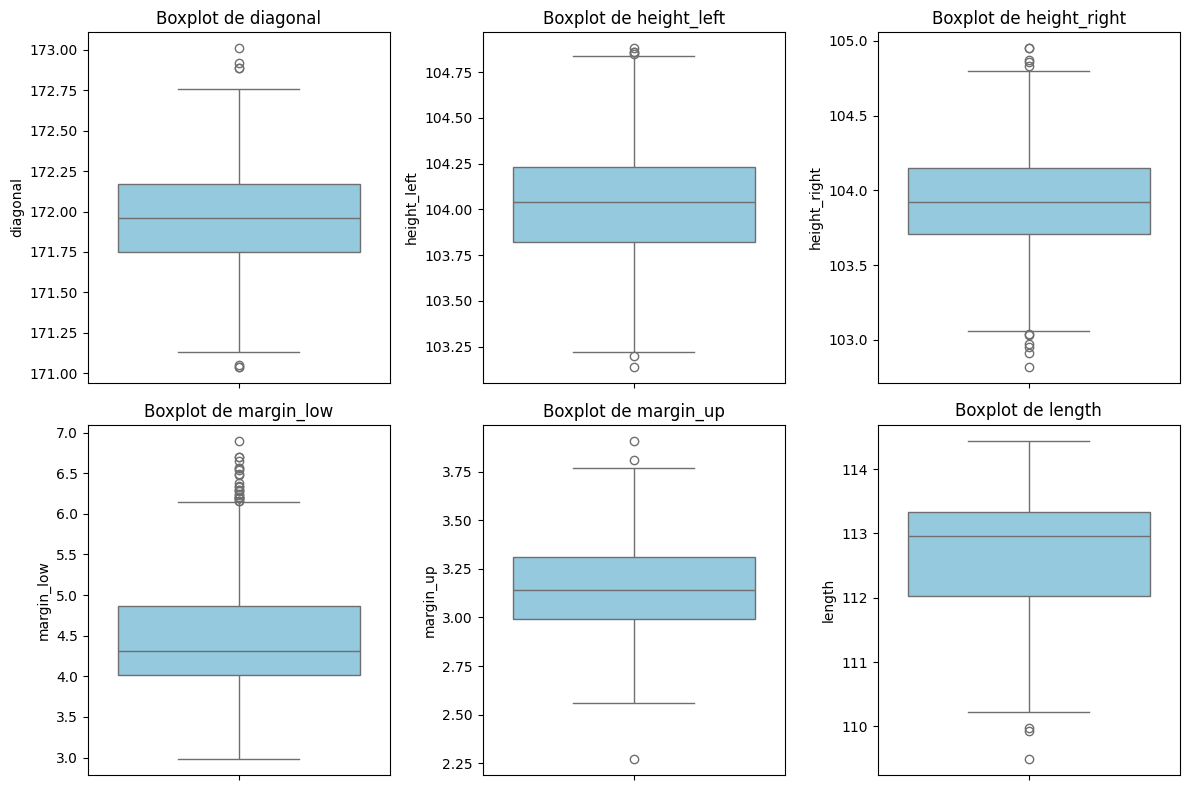

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
for i, col in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col], color='skyblue')
    plt.title(f"Boxplot de {col}")
plt.tight_layout()
plt.show()


  ## **5.8 Pairplot**

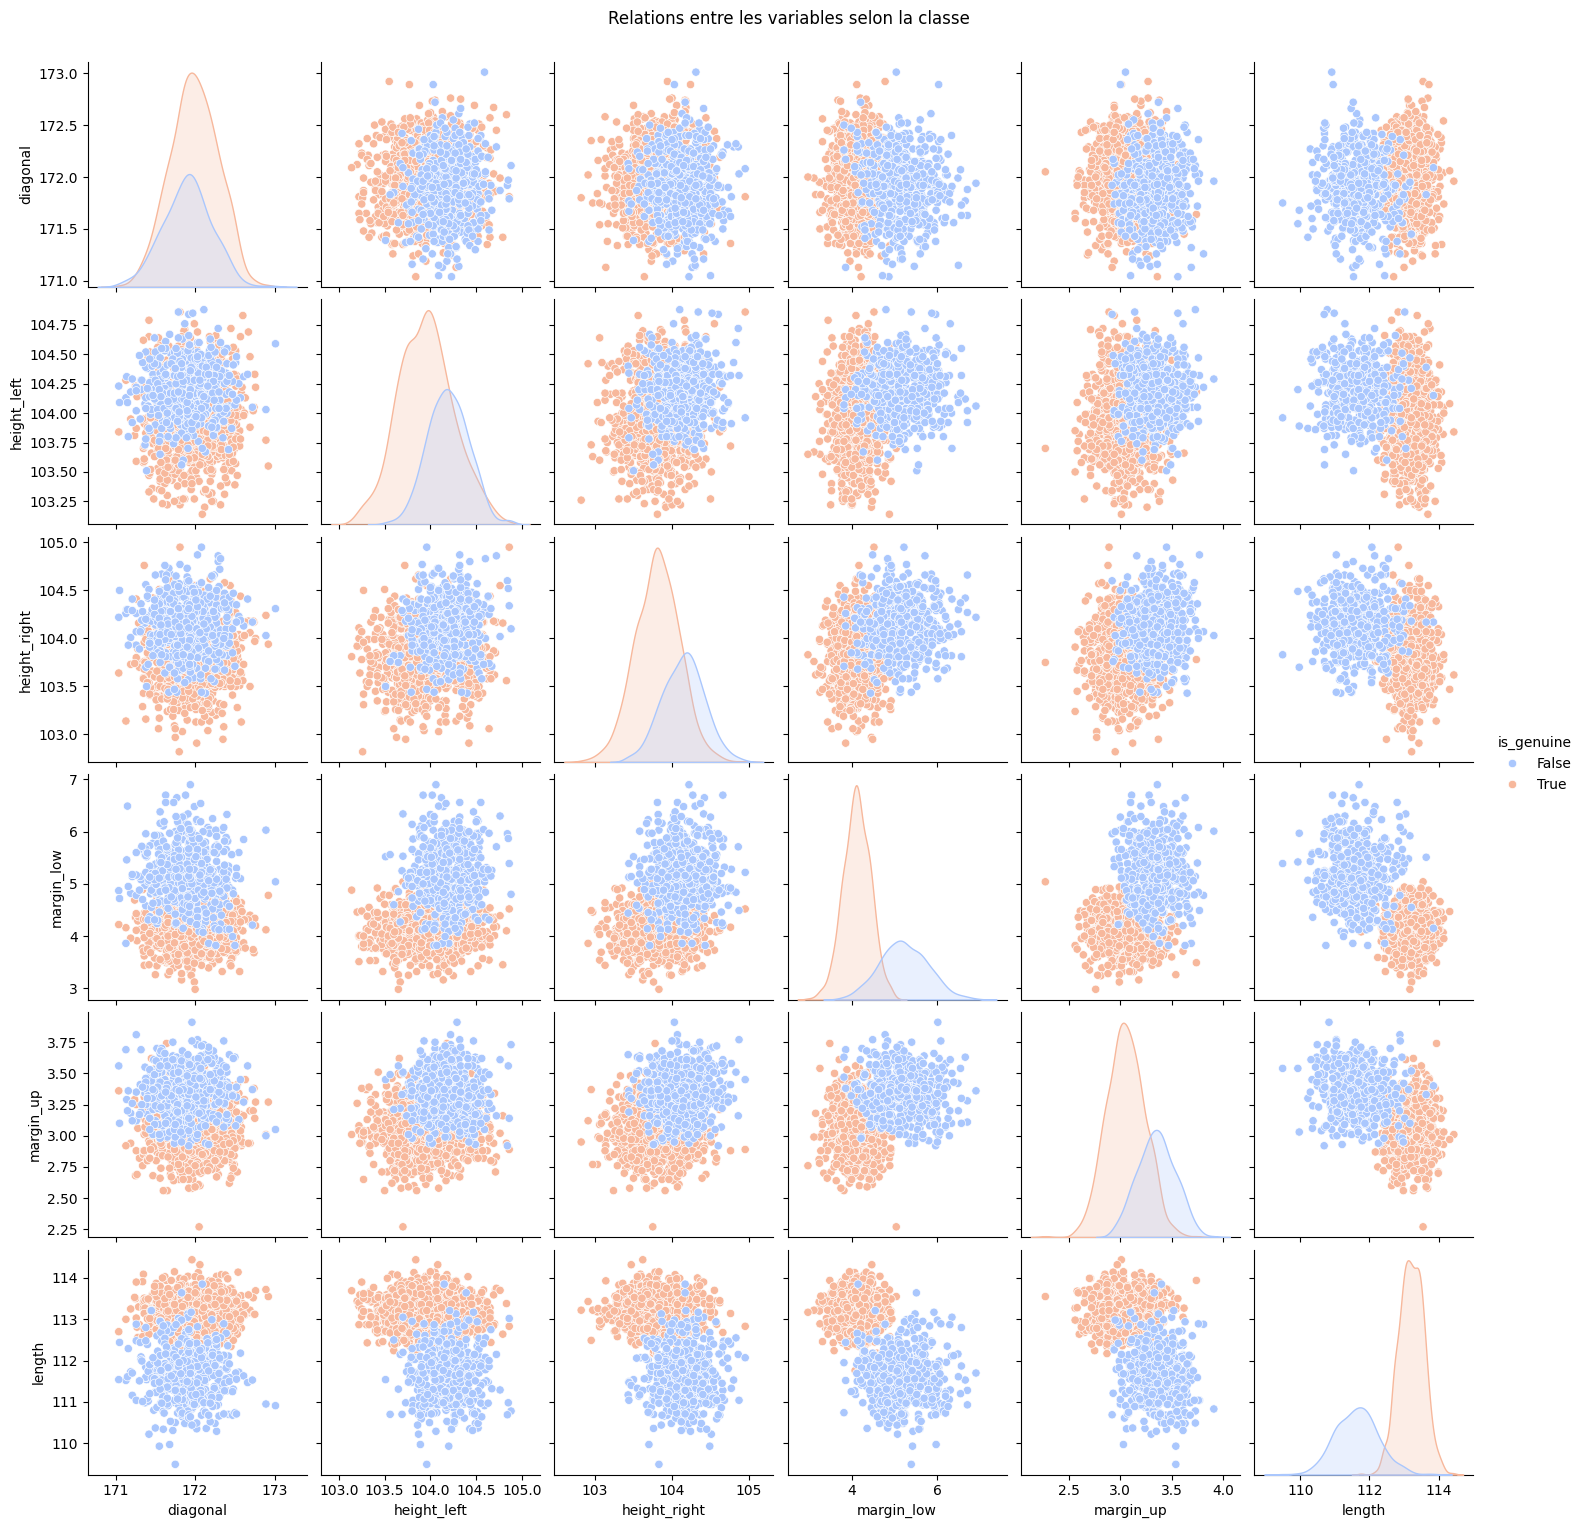

In [ ]:
sns.pairplot(df, vars=num_cols, hue='is_genuine', palette='coolwarm')
plt.suptitle("Relations entre les variables selon la classe", y=1.02)
plt.show()


# **6. Préparation des données**
>**Objectif :** Nettoyer, normaliser et préparer les données pour l’entraînement du modèle.

## **6.1 Gestion des valeurs manquantes**

Pour la gestion de valeurs manquantes , on a plusieurs possibilités :

**A. Suppression de données**
* 1. Supprimer les lignes avec des valeurs manquantes
* 2. Supprimer les colonnes avec trop de valeurs manquantes

**B. Imputation (remplissage)**
* 1. Valeur constante : ex. 0 ou -1
* 2. Moyenne : si pas de valeurs aberrantes importantes.
* 3. Médiane : si présence de valeurs aberrantes
* 4. Mode : pour les variables catégorielles, prend la première valeur la plus fréquente.

**C. Imputation basée sur d’autres variables**
* 1. **KNN Imputer** :  
    on regarde les observations les plus similaires (les    “voisins”) dans le dataset, selon les autres variables puis on remplace ensuite la valeur manquante par la moyenne (ou médiane) des voisins pour cette variable.

* 2. **Interpolation** :
    consiste à estimer les valeurs manquantes en utilisant les valeurs existantes voisines d’une même colonne, très utilisée pour les séries temporelles ou des données ordonnées.

**D. Méthodes plus avancées**
* 1. **Imputation multiple (Multiple Imputation)** :
    Génère plusieurs valeurs possibles pour les manquants et combine les résultats.

* 2. **Modélisation** :
    Construire un modèle (régression, arbre, etc.) pour prédire la valeur manquante en fonction des autres variables.

* 3. **Encodage d’une catégorie spéciale**
    Pour les variables catégorielles, créer une catégorie Unknown ou Missing.

Dans notre dataframe, selement **2,47% **des données de la colonne **margin_low** sont manquantes et vu que celle ci a des valeurs aberrantes, on remplace donc les données manquantes par la médiane.

In [ ]:
df['margin_low'] = df['margin_low'].fillna(df['margin_low'].median())

## **6.2  Gestion des doublons**

In [ ]:
df = df.drop_duplicates()

## **6.3  Gestion des valeurs aberrantes**

On a plusieurs possibilités :
* **A. Suppression des valeurs aberrantes**
* **B. Transformation des valeurs aberrantes** :
  * **Winsorisation** : Remplace les valeurs extrêmes par le quantile le plus proche.
  * **Transformation logarithmique / racine carrée** : Réduit l’effet des grandes valeurs sur le modèle.
  * **Clipping (bornage)** : Limiter les valeurs à des bornes min/max définies.
* **C. Imputation des outliers**
  **D. Remplacer les valeurs aberrantes par des valeurs plus “raisonnables”:**
  * Moyenne ou médiane de la colonne
  * Valeur du quantile approprié
* **E. Modèles robustes aux outliers**
    * Certains modèles sont moins sensibles aux outliers, ce qui permet de les conserver : Arbres de décision, Random Forest, XGBoost
    
    * Les modèles linéaires (régression logistique, SVM linéaire) sont plus sensibles.


**Analyse séparée**

>Dans notre cas, on peut conserver les outliers comme une classe particulière : les faux billets extrêmes peuvent être considérés comme des outliers, mais on veux les détecter.

## **6.4 Séparation des variables explicatives et de la cible**

In [ ]:
X = df.drop("is_genuine", axis=1)
y = df["is_genuine"]


## **6.5 Normalisation des données**

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
# Sauvegarder le scaler
joblib.dump(scaler, os.path.join(save_dir,"scaler.pkl"))


['/content/drive/MyDrive/saved_models/detection_faux_billets/scaler.pkl']


## **6.6 Découpage en jeu d’entraînement et de test**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


# **7.1 Modélisation – Régression Logistique**

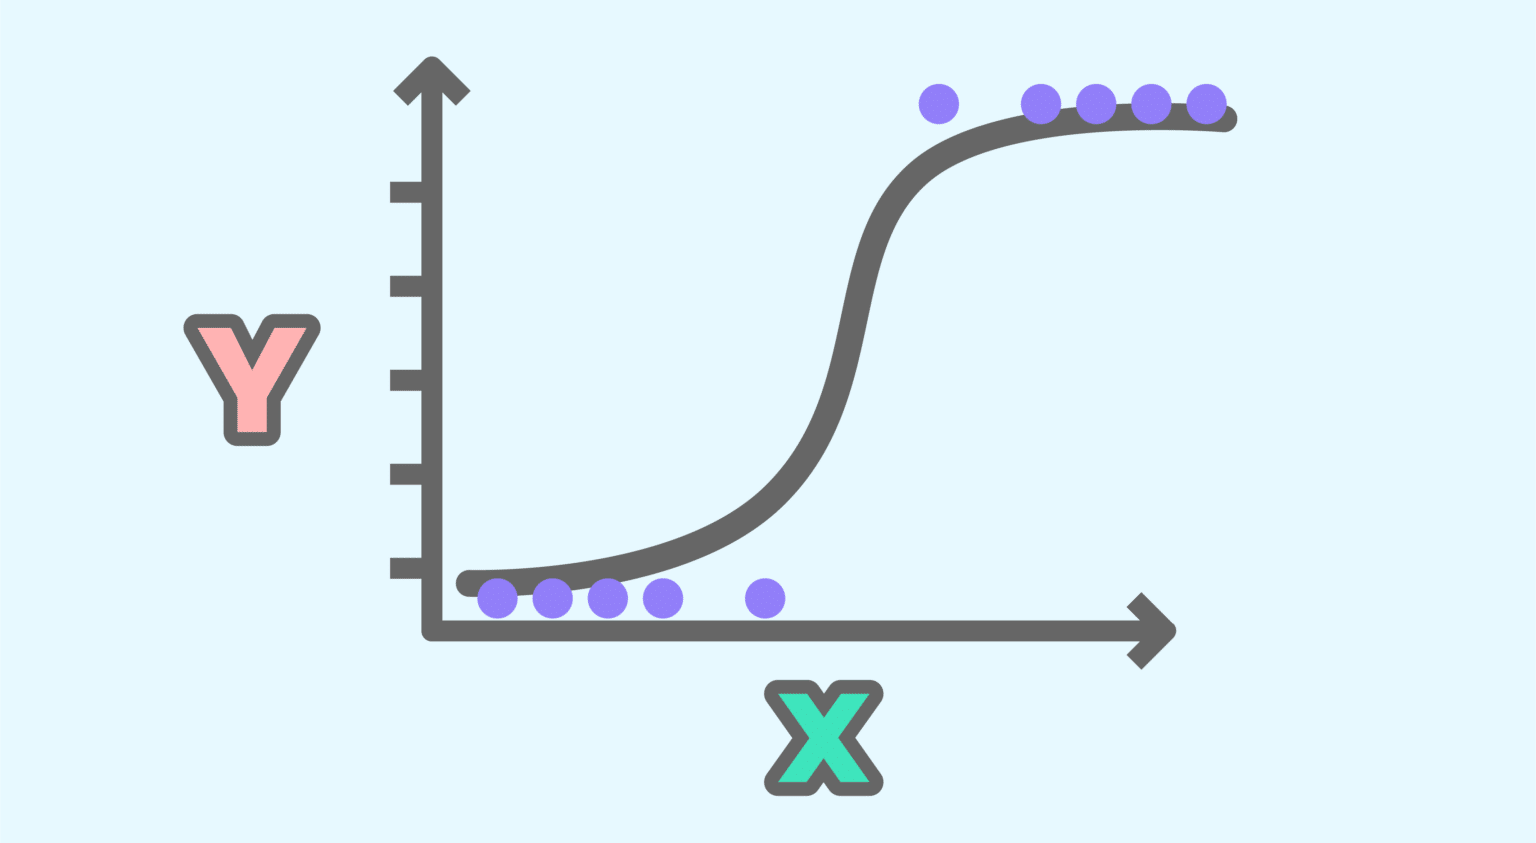

## **7.1.1 Entraînement du modèle**

In [ ]:
model_RL = LogisticRegression()
model_RL.fit(X_train, y_train)


LogisticRegression()

## **7.1.2 Prédictions**

In [ ]:
y_pred = model_RL.predict(X_test)
y_proba = model_RL.predict_proba(X_test)[:,1]

## **7.1.3 Évaluation du modèle**

In [ ]:
# Calcul des métriques
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy : {acc:.3f}")
print(f"Precision : {prec:.3f}")
print(f"Recall : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"AUC-ROC : {auc:.3f}")


Accuracy : 0.990
Precision : 0.990
Recall : 0.995
F1-score : 0.993
AUC-ROC : 0.999


## **7.1.4 Matrice de confusion**

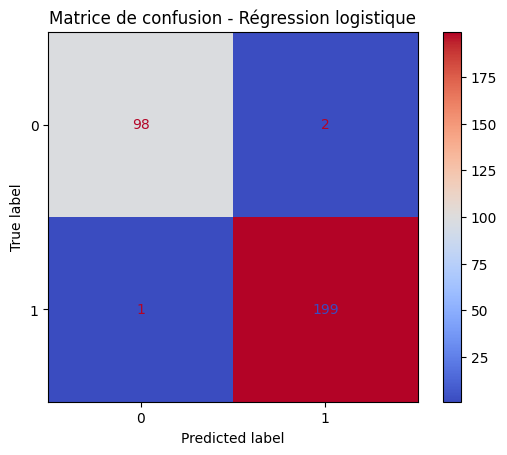

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='coolwarm')
plt.title("Matrice de confusion - Régression logistique")
plt.show()


## **7.1.5 Courbe ROC**

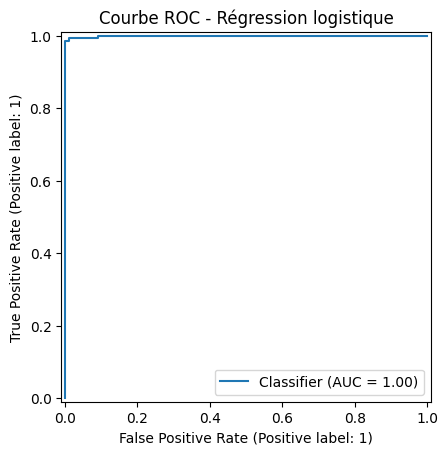

In [ ]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Courbe ROC - Régression logistique")
plt.show()


## **7.1.6 Interprétation des coefficients**

**Les coefficients positifs** indiquent une plus forte probabilité d’être un vrai billet.

**Les coefficients négatifs** indiquent une probabilité plus forte d’être un faux billet.

/tmp/ipython-input-2307380695.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x="Coefficient", y="Variable", palette="coolwarm")


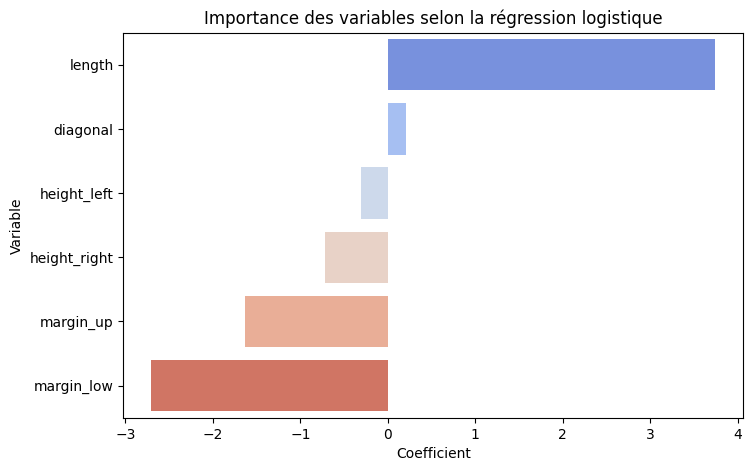

In [ ]:
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coefficient": model_RL.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(8, 5))
sns.barplot(data=coef_df, x="Coefficient", y="Variable", palette="coolwarm")
plt.title("Importance des variables selon la régression logistique")
plt.show()


# **8.1 Optimisation du modèle**

> **Objectif**
    
    Améliorer la performance du modèle via validation croisée et ajustement des hyperparamètres.

## **8.1.1 Validation croisée**

In [ ]:
scores = cross_val_score(model_RL, X_scaled, y, cv=5, scoring='accuracy')
print(f"Le modèle atteint environ  {scores.mean() * 100:.2f}% de précision avec une variation de ± {scores.std():.3f} selon les sous-ensembles testés.")


Le modèle atteint environ  99.00% de précision avec une variation de ± 0.004 selon les sous-ensembles testés.


## **8.1.2 Recherche d’hyperparamètres (Grid Search)**

In [ ]:
# Définition des grilles compatibles
param_grid = [
    {
        'solver': ['liblinear'],
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100], #pénalité appliquée aux poids du modèle pour éviter le surapprentissage
        'max_iter': [1000]
    },
    {
        'solver': ['lbfgs', 'newton-cg', 'sag'],
        'penalty': ['l2', None],
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [1000]
    },
    {
        'solver': ['saga'],
        'penalty': ['l1', 'l2', 'elasticnet', None],
        'C': [0.01, 0.1, 1, 10, 100],
        'l1_ratio': [0, 0.5, 1],  # pour elasticnet
        'max_iter': [1000]
    }
]

# Initialisation du GridSearch
grid = GridSearchCV(
    LogisticRegression(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # utiliser tous les cœurs pour accélérer
    verbose=2
)

# Entraînement
grid.fit(X_train, y_train)

# Résultats
print("Meilleurs paramètres :", grid.best_params_)
print(f"Meilleure accuracy moyenne (CV=5) : {grid.best_score_:.4f}")

# Évaluation sur le test set

y_pred = grid.best_estimator_.predict(X_test)
print("Accuracy sur le jeu de test :", accuracy_score(y_test, y_pred))
print("Rapport de classification :\n", classification_report(y_test, y_pred))


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Meilleurs paramètres : {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}
Meilleure accuracy moyenne (CV=5) : 0.9942
Accuracy sur le jeu de test : 0.9866666666666667
Rapport de classification :
               precision    recall  f1-score   support

       False       0.99      0.97      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



## **8.1.3 Sauvegarde du modèle**

In [ ]:
# Récupérer le meilleur modèle entraîné
best_rl = grid.best_estimator_

# Sauvegarder le modèle
joblib.dump(best_rl, os.path.join(save_dir,'logistic_regression_best_model.pkl'))

# # Recharger le modèle plus tard
# loaded_model = joblib.load('logistic_regression_best_model.pkl')



['/content/drive/MyDrive/saved_models/detection_faux_billets/logistic_regression_best_model.pkl']

## **8.1.4 Analyse des coefficients**

In [ ]:
features = ['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']

coeffs = pd.DataFrame({
    'Variable': features,
    'Coefficient': grid.best_estimator_.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coeffs)


       Variable  Coefficient
5        length     2.995064
0      diagonal     0.000000
1   height_left    -0.039908
2  height_right    -0.335452
4     margin_up    -0.914065
3    margin_low    -1.994626


# **9.1 Analyse et conclusion**

**La régression logistique régularisée (L1)** s’est révélée très performante pour la détection de faux billets :

Excellente **précision globale** (~99 %),

Très bon équilibre entre **précision** et **rappel**,

Forte généralisation grâce à la **régularisation**,

Interprétabilité claire (coefficients).

> Ce modèle constitue une base solide pour la détection automatique de contrefaçons.

# **7.2 Modélisation - Random Forest**

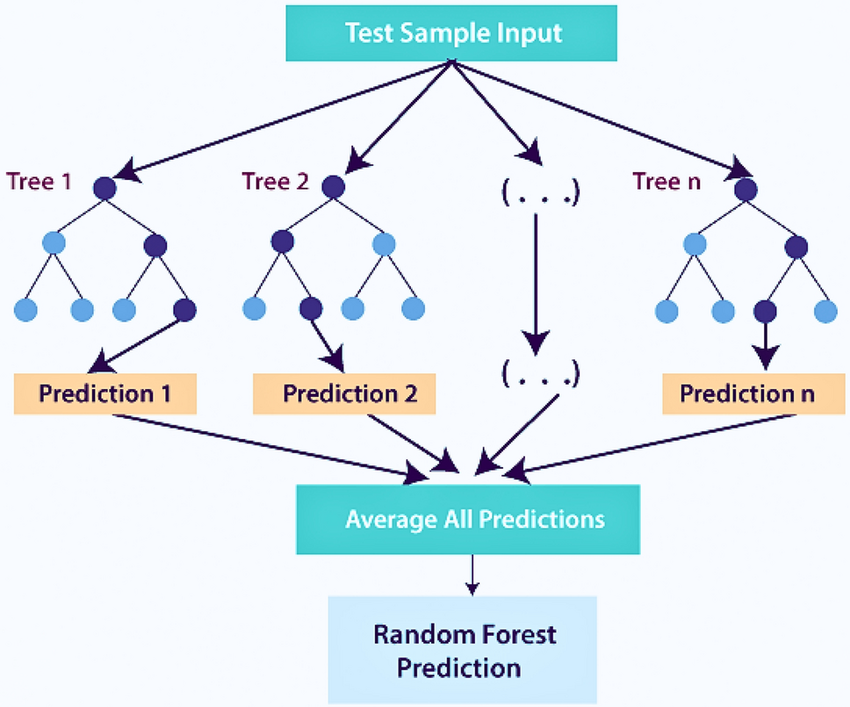

## **7.2.1 Entraînement du modèle**

In [ ]:
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## **7.2.2 Prédictions**

In [ ]:
y_pred = model_RF.predict(X_test)



## **7.2.3 Évaluation du modèle**

In [ ]:
print("Accuracy test:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy test: 0.99
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



## **7.2.4 Matrice de confusion**

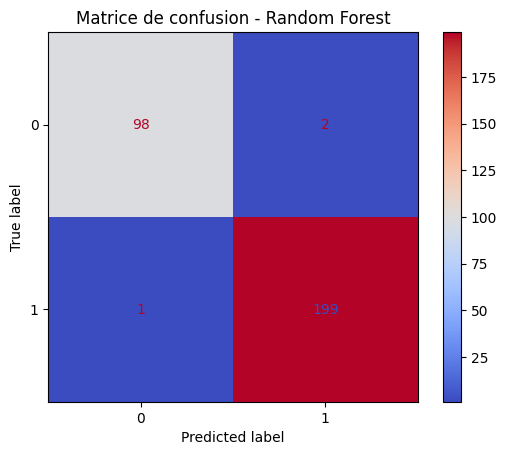

In [ ]:
cm2 = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm2).plot(cmap='coolwarm')
plt.title("Matrice de confusion - Random Forest")
plt.show()


## **8.2 Optimisation du modèle - Random Forest**

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500], #nombre d’arbres dans la forêt.
    'max_depth': [None, 5, 10, 20],  #profondeur maximale d’un arbre.
    'min_samples_split': [2, 5, 10],  #nombre minimum d’échantillons requis pour diviser un noeud.
    'min_samples_leaf': [1, 2, 4],   #nombre minimum d’échantillons requis dans une feuille terminale.
    'max_features': ['sqrt', 'log2', None] #nombre de features à considérer pour chaque division.
}

grid = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleure accuracy CV :", grid.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Meilleurs paramètres : {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Meilleure accuracy CV : 0.9916666666666666


### **8.2.1 Sauvegarde du meilleur modèle - Random Forest**

In [ ]:
# grid.best_estimator_ est le modèle entraîné avec les meilleurs paramètres
best_rf = grid.best_estimator_

# Sauvegarder le modèle
joblib.dump(best_rf, os.path.join(save_dir,'random_forest_best_model.pkl'))

# # Pour recharger plus tard
# loaded_model = joblib.load('random_forest_best_model.pkl')


['/content/drive/MyDrive/saved_models/detection_faux_billets/random_forest_best_model.pkl']

## **8.2.2 Evaluation du modèle optimisé**

Accuracy test: 0.99
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



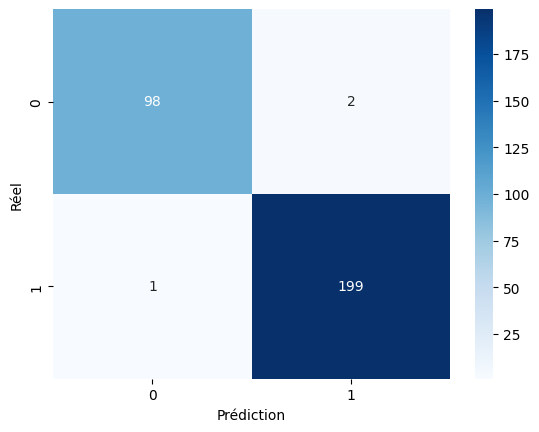

In [ ]:
best_rf = grid.best_estimator_
y_pred_test = best_rf.predict(X_test)

print("Accuracy test:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()


## **8.2.3 Importance des variables**

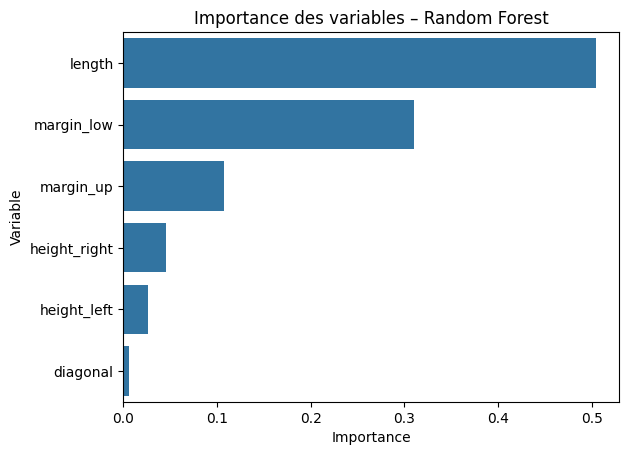

In [ ]:

feature_importances = pd.DataFrame({
    'Variable': features,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Variable', data=feature_importances)
plt.title('Importance des variables – Random Forest')
plt.show()


# **9.2 Analyse et conclusion**

Le modèle **Random Forest** détecte très efficacement les faux billets avec une **accuracy > 0.99**.

Il est robuste et capable de capturer des relations complexes entre les dimensions des billets.

Les hyperparamètres optimisés permettent un bon compromis entre **précision** et **généralisation**.

L’analyse des importances des variables fournit une interprétation claire pour la banque : certaines dimensions sont cruciales pour identifier les contrefaçons.

# **7.3 Modélisation - XGBoost**

## **7.3.1 Entraînement du modèle**

In [ ]:
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:03:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## **7.3.2 Prédictions**

In [ ]:
y_pred = model_xgb.predict(X_test)


## **7.3.3 Évaluation du modèle**



In [ ]:
print("Accuracy test:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy test: 0.9866666666666667
              precision    recall  f1-score   support

       False       0.98      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



## **7.3.4 Matrice de confusion**

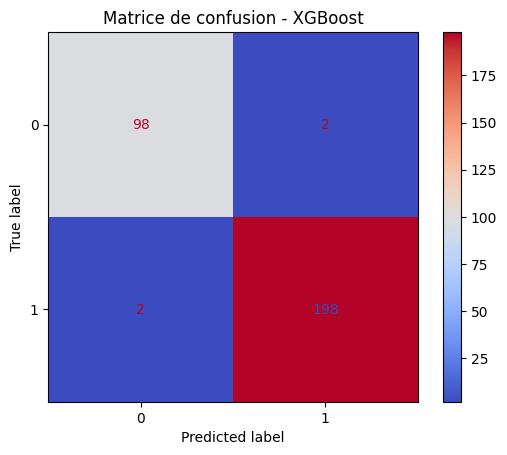

In [ ]:
cm3 = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm3).plot(cmap='coolwarm')
plt.title("Matrice de confusion - XGBoost")
plt.show()


## **8.3 Optimisation du modèle - XGBoost**

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'gamma': [0, 0.1, 0.3]
}

grid = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleure accuracy CV :", grid.best_score_)


Fitting 5 folds for each of 972 candidates, totalling 4860 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [22:07:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meilleurs paramètres : {'colsample_bytree': 0.7, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'subsample': 1}
Meilleure accuracy CV : 0.9908333333333333


## **8.3.1 Evaluation du modèle optimisé**

Accuracy test: 0.9833333333333333
              precision    recall  f1-score   support

       False       0.98      0.97      0.97       100
        True       0.99      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



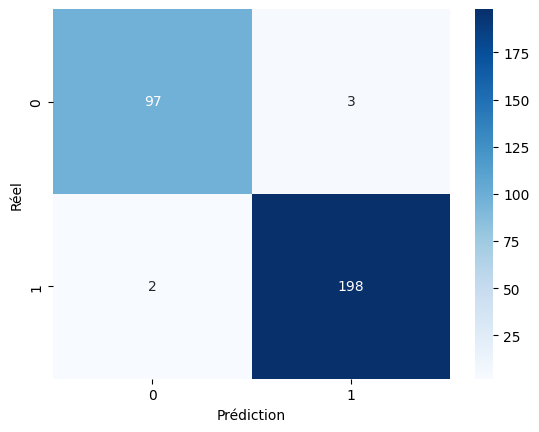

In [ ]:
best_xgb = grid.best_estimator_
y_pred_test = best_xgb.predict(X_test)

print("Accuracy test:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_test, y_pred_test))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Prédiction')
plt.ylabel('Réel')
plt.show()


## 8.3.2 **Sauvegarde du meilleur modèle**

In [ ]:
# Sauvegarder le modèle
joblib.dump(best_xgb, os.path.join(save_dir,'XGBoost_best_model.pkl'))




['/content/drive/MyDrive/saved_models/detection_faux_billets/XGBoost_best_model.pkl']

## **8.3.3 Importance des variables**

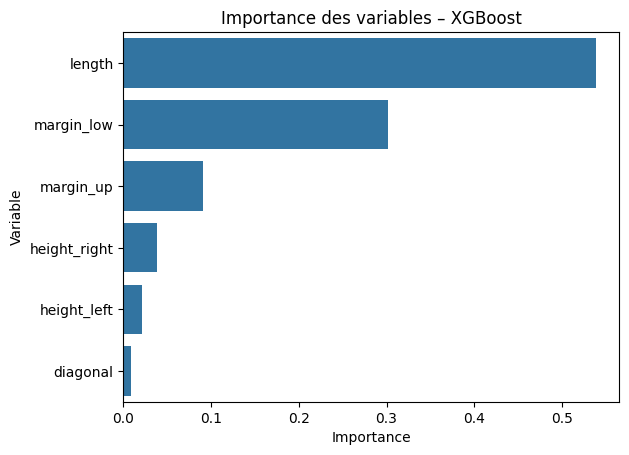

In [ ]:
feature_importances = pd.DataFrame({
    'Variable': features,
    'Importance': best_xgb.feature_importances_
}).sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Variable', data=feature_importances)
plt.title('Importance des variables – XGBoost')
plt.show()


# **9.3 Analyse et conclusion**

**Performance** : XGBoost atteint une accuracy ≈ 0.991, comparable voire légèrement meilleure que Random Forest.

**Robustesse** : le modèle capture des relations complexes et corrige progressivement les erreurs sur les cas difficiles.

# **Histogramme comparatif des 3 modèles**

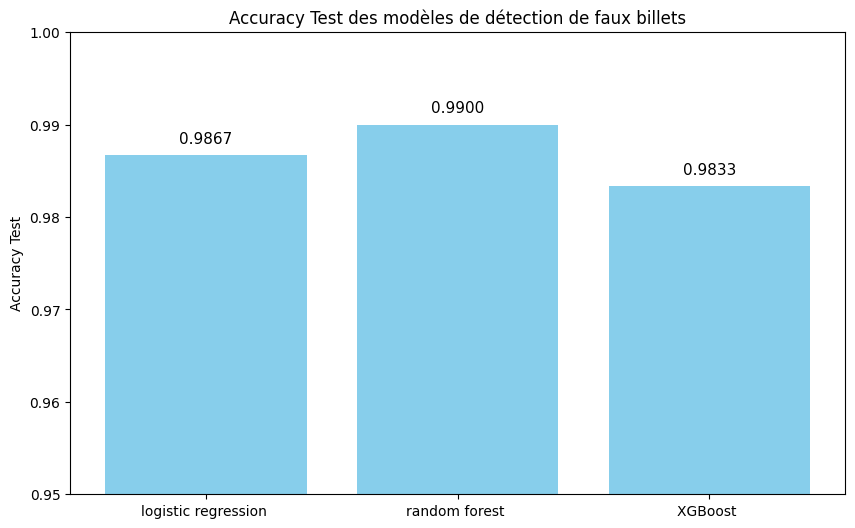

In [ ]:
# Liste des fichiers modèles
model_files = ['logistic_regression_best_model.pkl',
               'random_forest_best_model.pkl',
               'XGBoost_best_model.pkl']


# Stockage des résultats
models = []
accuracy_test = []

# Calcul de l'accuracy test pour chaque modèle
for file in model_files:
    model_path = os.path.join(save_dir, file)
    model = joblib.load(model_path)

    # Nom du modèle (extrait du nom du fichier)
    model_name = file.split('best')[0]
    model_name = model_name.replace("_", " ")
    models.append(model_name)

    # Accuracy sur le jeu de test
    y_pred = model.predict(X_test)
    acc_test = accuracy_score(y_test, y_pred)
    accuracy_test.append(acc_test)

# Création de l'histogramme
plt.figure(figsize=(10,6))
bars = plt.bar(models, accuracy_test, color='skyblue')

# Ajouter les valeurs au-dessus de chaque barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.001, f'{height:.4f}',
             ha='center', va='bottom', fontsize=11)

plt.ylim(0.95, 1.0)
plt.ylabel('Accuracy Test')
plt.title("Accuracy Test des modèles de détection de faux billets")
plt.show()
